# Youtube Spam Comment 


We will implement \
<b> 1. MLP </b> \
<b> 2. CNN </b> \
<b> 3. LSTM </b> 

The data set was taken from UCI Machine Learning Repo
It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

Alberto, T. & Lochter, J. (2015). YouTube Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C58885.

## 1. Load libraries

In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import sys, re, bs4, nltk, sklearn, matplotlib
from bs4 import BeautifulSoup
import datasets, transformers 
from copy import deepcopy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#import gensim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report
from collections import defaultdict

## 2. Get data

In [1]:
pip install ucimlrepo


[notice] A new release of pip is available: 23.1.2 -> 25.1
[notice] To update, run: C:\Users\Ashutosh\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
youtube_spam_collection = fetch_ucirepo(id=380) 
  
# data (as pandas dataframes) 
X = youtube_spam_collection.data.features 
y = youtube_spam_collection.data.targets 
  
# metadata 
print(youtube_spam_collection.metadata) 
  
# variable information 
print(youtube_spam_collection.variables) 


{'uci_id': 380, 'name': 'YouTube Spam Collection', 'repository_url': 'https://archive.ics.uci.edu/dataset/380/youtube+spam+collection', 'data_url': 'https://archive.ics.uci.edu/static/public/380/data.csv', 'abstract': 'It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Text'], 'num_instances': 1956, 'num_features': 3, 'feature_types': [], 'demographics': [], 'target_col': ['CLASS'], 'index_col': ['VIDEO', 'COMMENT_ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C58885', 'creators': ['T.C. Alberto', 'J.V. Lochter'], 'intro_paper': None, 'additional_info': {'summary': 'The table below lists the datasets, the YouTube video ID, the amount of samples in ea

## 3. Methodology

We will prepeocess the data, tokenize, clean it (stemming, lemmization), encode it (bag of words, tf-idf), then use multiple methodes to classify it and compare resutls

    ```Input data
    pre-processing
        A --> Toeknization
        B --> Stemming/Lemmization
        C --> Encoding (Bag of Words, TF-IDF)
    Create Embeddings
        D --> GLOVE
        E --> Word2Vec- CBOW
        F --> Word2Vec - Skipgram
    DL Model
        G. --> Define model
        H. --> Train model
        I. --> Evaluate

In [3]:
for i in X['CONTENT'][0:5]:
    print(i)

Huh, anyway check out this you[tube] channel: kobyoshi02
Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
just for test I have to say murdev.com
me shaking my sexy ass on my channel enjoy ^_^ ﻿
watch?v=vtaRGgvGtWQ   Check this out .﻿


## 4. Data Cleaning

In [4]:
# We want to remove URL as comment as it will confuse the model but we will keep a flag that a url watch present here, 
#as it might be a strong indicator of a spam comment

X_all = [re.sub(r'http\S+|www\S+|https\S+', 'url', i, flags=re.MULTILINE) for i in X['CONTENT']]

# Similarly for watch, we will remove complext suffix but keep the word watch as an input to out model
X_all = [re.sub(r'watch\?v=\S+', 'watch', i, flags=re.MULTILINE) for i in X_all]

# Remove any html tags by mistake
X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]

# for any emoji or emoticon replace it with the word "emoji" as it can be a useful feature
X_all = [re.sub("[:;][)|(DP]","emoji",i) for i in X_all]

# any number does not look like year should be replaced with an identifier number

def not_number(string):
    string = re.sub(",","",string)
    try:
        float(string)
        return False
    except ValueError:
        return True
    
def check_range(string_no):
    string_no = re.sub(",","",string_no)
    if(float(string_no) <= 2100.0 and float(string_no) >= 1800.0):
        return(True)
    else:
        return(False)

def remove_suprious_num(snt):
    token_words = word_tokenize(snt)
    changed_words = [i if not_number(i) else "year" if  check_range(i) else "large number" for i in token_words]
    return(" ".join(changed_words))

X_all = [remove_suprious_num(i) for i in X_all]

# convert all to lower case
X_all = [i.casefold() for i in X_all]

# romve extra white space 
X_all = [re.sub(r'[^\w\s]', '', i) for i in X_all]

X_all = [re.sub(r'\s+', ' ', i).strip() for i in X_all]



C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_31492\787672344.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]


## 4. Split into test and train data

In [5]:
# Let us check the distirbution of labels, if it is highly imbalanced
y.value_counts()

CLASS
1        1005
0         951
Name: count, dtype: int64

The labels seem to be very well balanced, hence we need not worry about sampling techniques (oversampling/undersampling/smote,etc).

In [6]:
# we will use y to stratify so the distribution of labels is simialr in training and test data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

Let us check the distribution in training and test data

In [7]:
print(y_train.value_counts())
print(y_test.value_counts())

CLASS
1        804
0        760
Name: count, dtype: int64
CLASS
1        201
0        191
Name: count, dtype: int64


## 5. Pre-processing and tokenization

### 5a. Remove stop words

In [8]:
#print(stopwords)
stop_words = set(stopwords.words("english"))

In [9]:
def remove_stop_words(sent):
    token_words = word_tokenize(sent)
    clean_token_words = [i for i in token_words if i not in stop_words]
    return(" ".join(clean_token_words))

In [10]:
X_train = [remove_stop_words(i) for i in X_train]
X_test = [remove_stop_words(i) for i in X_test]
X_train[0:10]

['video large number views large number million people earth',
 'head like large number years ago time flies',
 'large number billions year',
 'wtf subscribe channel thanx emoji',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta large number gameplay right watch',
 'remember back popular everyone school shuffling crazy',
 'url please halp project',
 'haha funny see salt westerners top views youtube goes video dont even understand keep salt']

### 5b. Normalization - Lemmization

In [11]:
def normalize_data(sent,lemmitizer):
    token_words = word_tokenize(sent)
    clean_tokens = [lemmitizer.lemmatize(i) for i in token_words]
    return(" ".join(clean_tokens)) 

lemmitizer = WordNetLemmatizer()
X_train = [normalize_data(i,lemmitizer) for i in X_train]
X_test = [normalize_data(i,lemmitizer) for i in X_test]
X_train[0:10]

['video large number view large number million people earth',
 'head like large number year ago time fly',
 'large number billion year',
 'wtf subscribe channel thanx emoji',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta large number gameplay right watch',
 'remember back popular everyone school shuffling crazy',
 'url please halp project',
 'haha funny see salt westerner top view youtube go video dont even understand keep salt']

## Word Encodings

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

# fit data to tfidf
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)


## Creating training data

In [13]:
import torch
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
X_tensor_train = torch.tensor(train_tfidf.toarray(), dtype=torch.float32)    
print(X_tensor_train.shape)

y_tensor_train = torch.tensor(np.array(y_train), dtype=torch.float32)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=False,drop_last=False)

torch.Size([1564, 2957])


### Testing dataset

In [24]:
X_tensor_test = torch.tensor(test_tfidf.toarray(), dtype=torch.float32)    
print(X_tensor_test.shape)
y_tensor_test = torch.tensor(np.array(y_test), dtype=torch.float32)

dataset_test = TensorDataset(X_tensor_test, y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False,drop_last=False)

torch.Size([392, 2957])


## Creating a simple neural networks

In [25]:
from torch import nn

# Define model
class SpamFilter(nn.Module):
    def __init__(self, input_size):
        super(SpamFilter, self).__init__()
        self.layer1 = nn.Linear(in_features=input_size,
                               out_features=128)
        
        self.layer2 = nn.Linear(in_features=128,
                               out_features=64 )
        
        self.layer3 = nn.Linear(in_features=64,
                               out_features=1 )
        
    def forward(self, x):
        out = torch.relu(self.layer1(x))
        out = torch.relu(self.layer2(out))
        out = torch.sigmoid(self.layer3(out))
        return out

In [26]:
# Initialize the model
input_size = train_tfidf.shape[1]
model0 = SpamFilter(input_size).to(device)

In [27]:
# loss function
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr=0.001)

In [28]:
# Training loop for deep learning
num_epochs = 10
for epoch in range(num_epochs):
    model0.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()

        outputs = model0(inputs)
        #print(outputs.shape)
        #print(labels.unsqueeze(1).shape)
        loss = criterion(outputs,labels)        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
     
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}')

Epoch 1/10, Loss: 72.17545211315155
Epoch 2/10, Loss: 14.981971125351265
Epoch 3/10, Loss: 5.190710291033611
Epoch 4/10, Loss: 2.2173233703360893
Epoch 5/10, Loss: 1.158027640383807
Epoch 6/10, Loss: 0.5482940032234183
Epoch 7/10, Loss: 0.287608772621752
Epoch 8/10, Loss: 0.1828751945940894
Epoch 9/10, Loss: 0.10912169448511122
Epoch 10/10, Loss: 0.0714688930693228


In [60]:
# Predictions on training data

model0.eval() 

train_preds = []
train_losses = []
test_losses = []
length = 0
length_of_pred = 0

with torch.no_grad(): 
    for inputs, labels in dataloader_train:  
        outputs_train = model0(inputs) 
        length += labels.shape[0]
        predicted = np.array((outputs_train > 0.5).float())
        #print(predicted)
        #print("this")
        preds = np.array([item[0] for item in predicted])
        length_of_pred += preds.shape[0]
        train_preds.extend(preds)
        
# Predictions on testing data

model0.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test:  
        #print(i)
        i += 1
        #print(labels)
        outputs_test = model0(inputs) 
        predicted = np.array((outputs_test > 0.5).float())
        preds = np.array([item[0] for item in predicted])
        test_preds.extend(preds)

## Measure accuracy

In [61]:
# Training accuracy
train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
test_accuracy = accuracy_score(y_test, test_preds)

train_precision = precision_score(y_train, train_preds)
test_precision = precision_score(y_test, test_preds)

train_recall = recall_score(y_train, train_preds)
test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(train_accuracy,3)))
print("test accuracy is {0}".format(round(test_accuracy,3)))

print("training precision is {0}".format(round(train_precision,3)))
print("test precision is {0}".format(round(test_precision,3)))

print("training recall is {0}".format(round(train_recall,3)))
print("test recall is {0}".format(round(test_recall,3)))

print(classification_report(y_test, test_preds))

training accuracy is 1.0
test accuracy is 0.926
training precision is 1.0
test precision is 0.922
training recall is 1.0
test recall is 0.935
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       191
           1       0.92      0.94      0.93       201

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



# CNN & RNN Model 

For using nn.embeddings, we need to create a token indicx sequence

In [83]:
# Tokenize sentences
token_words = []
for index,text in enumerate(X_train):
    word_list = word_tokenize(text)
    token_words.append(word_list)

In [154]:
# Tokenize sentences for test data
token_words_test = []
for index,text in enumerate(X_test):
    word_list = word_tokenize(text)
    token_words_test.append(word_list)

In [87]:
# Create a word dictionary

word_counts = defaultdict(int)

# Count word frequencies
for sent in token_words:
    for word in sent:
        word_counts[word] += 1

# Filter out dictionary elements where value is less than certain frequency

filtered_word_count = {word: count for word, count in word_counts.items() if count >= 5}

(array([1.237e+03, 1.630e+02, 6.700e+01, 4.600e+01, 3.000e+01, 1.700e+01,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  0. ,  10.7,  21.4,  32.1,  42.8,  53.5,  64.2,  74.9,  85.6,
         96.3, 107. ]),
 <BarContainer object of 10 artists>)

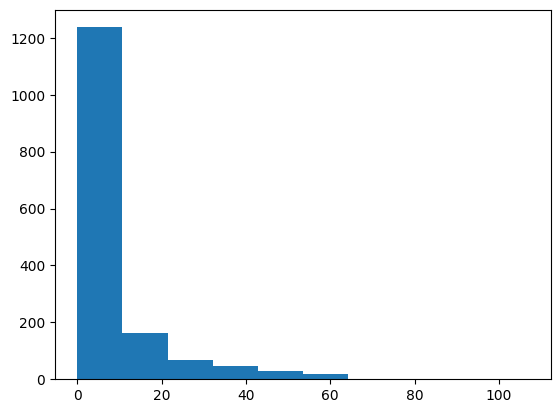

In [91]:
len_of_sentences = []
for i in token_words:
    len_of_sentences.append(len(i))
    
plt.hist(len_of_sentences)

In [94]:
# Let us tokenize it at 20 words
padded_text = []
for i in token_words:
    if len(i) > 20:
        sent = i[0:20]
    else:
        sent = i + ['<PAD>'] * (20 - len(i))
    padded_text.append(sent)


In [155]:
# Let us tokenize it at 20 words
padded_text_test = []
for i in token_words_test:
    if len(i) > 20:
        sent = i[0:20]
    else:
        sent = i + ['<PAD>'] * (20 - len(i))
    padded_text_test.append(sent)


(array([   0.,    0.,    0.,    0.,    0., 1564.,    0.,    0.,    0.,
           0.]),
 array([19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5]),
 <BarContainer object of 10 artists>)

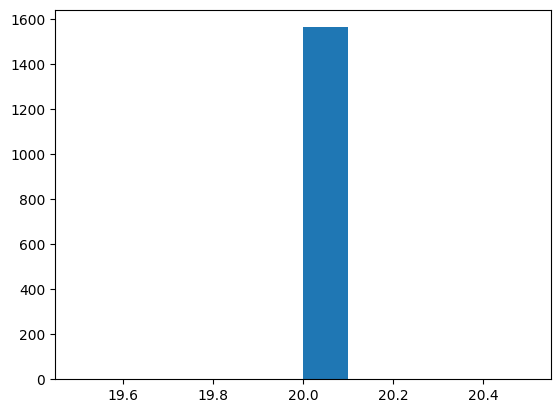

In [95]:
len_of_sentences = []
for i in padded_text:
    len_of_sentences.append(len(i))
    
plt.hist(len_of_sentences)

In [96]:
# Now let us create a tken indexes from the padded text

In [100]:
vocab = {
    "<PAD>": 0,
    "<UNK>": 1
}

for token in filtered_word_count:
    vocab[token] = len(vocab)

In [101]:
token_to_idx = defaultdict(lambda: vocab["<UNK>"])
token_to_idx.update(vocab)

In [102]:
word_index_sentences = []
for sent in padded_text:
    wrd_index = [token_to_idx[token] for token in sent]
    word_index_sentences.append(wrd_index)

In [156]:
word_index_sentences_test = []
for sent in padded_text_test:
    wrd_index = [token_to_idx[token] for token in sent]
    word_index_sentences_test.append(wrd_index)

In [105]:
np.array(word_index_sentences).shape

(1564, 20)

In [106]:
word_index_sentences[0]

[2, 3, 4, 5, 3, 4, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [118]:
vocab_size = len(vocab)

## Create training tensor dataset 

In [157]:
X_tensor = torch.tensor(np.array(word_index_sentences), dtype=torch.long)     
y_tensor = torch.tensor(np.array(y_train['CLASS']), dtype=torch.long)  

dataset_train = TensorDataset(X_tensor, y_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=False,drop_last=False)
 
    
X_tensor_test = torch.tensor(np.array(word_index_sentences_test), dtype=torch.long)     
y_tensor_test = torch.tensor(np.array(y_test['CLASS']), dtype=torch.long)  

dataset_test = TensorDataset(X_tensor_test, y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False,drop_last=False)

# CNN Model

## Define the model

In [160]:
class cnn_spam_classify(nn.Module):
    def __init__(self, embed_dim=50, num_classes=2,out_channel1 = 150, out_channel2 = 75, kernel_size = 3):
        super(cnn_spam_classify, self).__init__()
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=out_channel1, kernel_size=kernel_size, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.conv2 = nn.Conv1d(in_channels=out_channel1, out_channels=out_channel2, kernel_size=kernel_size, padding=2)
        self.fc = nn.Linear(out_channel2, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0,2,1)
        #print(x.shape)
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x).squeeze(2) 
        x = self.fc(x)
        return x


In [161]:
model = cnn_spam_classify()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses = [] 

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader_train:
        outputs = model(inputs)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)

    #print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
 


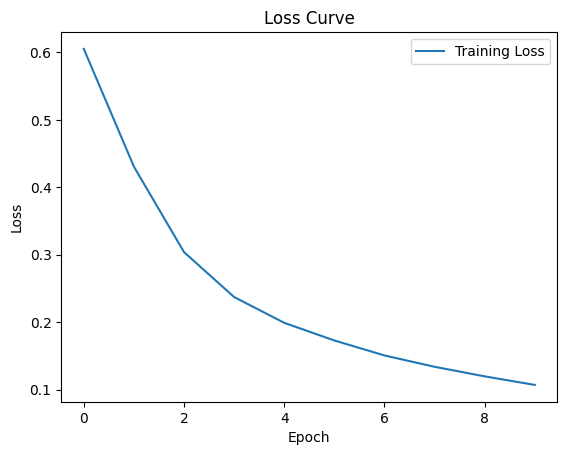

In [162]:

plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [163]:
# Predictions on training data

model.eval() 

train_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_train:  
        outputs_train = model(inputs) 
        preds = torch.argmax(outputs_train, dim=1) 
        train_preds.extend(preds.numpy())


In [164]:
model.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test:  
        outputs_test = model(inputs) 
        preds = torch.argmax(outputs_test, dim=1) 
        test_preds.extend(preds.numpy())

In [165]:
# Training accuracy
cnn_train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
cnn_test_accuracy = accuracy_score(y_test, test_preds)

cnn_train_precision = precision_score(y_train, train_preds)
cnn_test_precision = precision_score(y_test, test_preds)

cnn_train_recall = recall_score(y_train, train_preds)
cnn_test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(cnn_train_accuracy,3)))
print("test accuracy is {0}".format(round(cnn_test_accuracy,3)))

print("training precision is {0}".format(round(cnn_train_precision,3)))
print("test precision is {0}".format(round(cnn_test_precision,3)))

print("training recall is {0}".format(round(cnn_train_recall,3)))
print("test recall is {0}".format(round(cnn_test_recall,3)))

print(classification_report(y_train, train_preds))
print(classification_report(y_test, test_preds))

training accuracy is 0.971
test accuracy is 0.913
training precision is 0.975
test precision is 0.885
training recall is 0.969
test recall is 0.955
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       760
           1       0.97      0.97      0.97       804

    accuracy                           0.97      1564
   macro avg       0.97      0.97      0.97      1564
weighted avg       0.97      0.97      0.97      1564

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       191
           1       0.88      0.96      0.92       201

    accuracy                           0.91       392
   macro avg       0.92      0.91      0.91       392
weighted avg       0.92      0.91      0.91       392



# LSTM Model

In [178]:
class LSTM_spam_classify(nn.Module):
    def __init__(self, input_dim = 50, embed_dim = 50, hidden_dim = 100, output_dim = 2, n_layers=2, dropout=0.2):
        super(LSTM_spam_classify, self).__init__()
        self.embed =  nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        # lstm layer expects (batch_size, seq_len, input_size)
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.embed(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden_state = h_n[-1]  
        x = self.dropout(last_hidden_state)
        out = self.fc(x) 
        return out


In [181]:
model = LSTM_spam_classify()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloader_train:
        #inputs = inputs.float()
        #labels = labels.float()
        print(inputs.shape)
        print(labels.shape)
        outputs = model(inputs)
        print(outputs.shape)
        loss = criterion(outputs, labels)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        #get_norm()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)

    #print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
 

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6931, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.7125, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6585, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6909, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6861, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6541, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.7133, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6366, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6426, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6586, grad_fn=<NllLossBa

torch.Size([10, 2])
tensor(0.6402, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5655, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6382, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6608, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5817, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5729, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.8136, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6152, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6103, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.8128, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.S

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4602, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5362, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.7232, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4110, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4376, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5533, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3692, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6992, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3050, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2774, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6311, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3331, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1821, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4523, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4673, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4100, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6903, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2596, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1287, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4695, grad_fn=<NllLossBa

torch.Size([10, 2])
tensor(0.0694, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3485, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2284, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3045, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.8197, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0559, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3746, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3033, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0496, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2928, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.S

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3923, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5298, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2915, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0798, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4327, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1447, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0910, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0748, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0766, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5542, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0756, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0249, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6019, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0401, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0357, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4080, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0396, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1023, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1395, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4307, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0347, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1561, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(1.1909, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0205, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0481, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0172, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4010, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0769, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4435, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0190, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0372, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0370, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0405, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0348, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0279, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0250, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0229, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0279, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2161, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0224, grad_fn=<NllLossBa

torch.Size([10, 2])
tensor(0.0162, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4159, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2755, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0341, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0262, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0534, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0376, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0236, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0257, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4884, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.S

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0379, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0257, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0451, grad_fn=<NllLossBackward0>)
torch.Size([4, 20])
torch.Size([4])
torch.Size([4, 2])
tensor(0.0330, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0388, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0247, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0452, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1210, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0620, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3504, grad_fn=<NllLossBackw

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0605, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0154, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3801, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.4632, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0200, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3153, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0115, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0164, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0181, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0650, grad_fn=<NllLossBa

torch.Size([10, 2])
tensor(0.0274, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0299, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0192, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0197, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0210, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0141, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0132, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0220, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0202, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0111, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.S

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0195, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3288, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0160, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0279, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0240, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0300, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0187, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0219, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0233, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0193, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0089, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0149, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0858, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0092, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0107, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0110, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.5173, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0101, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0129, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0163, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0402, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0339, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0260, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.2344, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0449, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0319, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.1767, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0389, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0393, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0333, grad_fn=<NllLossBa

torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0172, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0200, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.3260, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0183, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0242, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0299, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.6642, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0112, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0235, grad_fn=<NllLossBackward0>)
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 2])
tensor(0.0122, grad_fn=<NllLossBa

In [182]:
# Predictions on training data

model.eval() 

train_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_train:  
        outputs_train = model(inputs) 
        preds = torch.argmax(outputs_train, dim=1) 
        train_preds.extend(preds.numpy())


In [183]:
model.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test:  
        outputs_test = model(inputs) 
        preds = torch.argmax(outputs_test, dim=1) 
        test_preds.extend(preds.numpy())

In [184]:
# Training accuracy
cnn_train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
cnn_test_accuracy = accuracy_score(y_test, test_preds)

cnn_train_precision = precision_score(y_train, train_preds)
cnn_test_precision = precision_score(y_test, test_preds)

cnn_train_recall = recall_score(y_train, train_preds)
cnn_test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(cnn_train_accuracy,3)))
print("test accuracy is {0}".format(round(cnn_test_accuracy,3)))

print("training precision is {0}".format(round(cnn_train_precision,3)))
print("test precision is {0}".format(round(cnn_test_precision,3)))

print("training recall is {0}".format(round(cnn_train_recall,3)))
print("test recall is {0}".format(round(cnn_test_recall,3)))

print(classification_report(y_train, train_preds))
print(classification_report(y_test, test_preds))

training accuracy is 0.977
test accuracy is 0.926
training precision is 0.996
test precision is 0.939
training recall is 0.959
test recall is 0.915
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       760
           1       1.00      0.96      0.98       804

    accuracy                           0.98      1564
   macro avg       0.98      0.98      0.98      1564
weighted avg       0.98      0.98      0.98      1564

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       191
           1       0.94      0.92      0.93       201

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392

